## Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

This work is copyright DeepSig Inc. 2017.
It is provided open source under the Create Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) Licence
https://creativecommons.org/licenses/by-nc/4.0/

Use of this work, or derivitives inspired by this work is permitted for non-commercial usage only and with explicit citaiton of this original work.

A more detailed description of this work can be found at
https://arxiv.org/abs/1602.04105

A more detailed description of the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Citation of this work is required in derivative works:

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

The RML2016.10a dataset is used for this work (https://radioml.com/datasets/)


In [25]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
# os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=cuda0"
import numpy as np
import theano as th
import theano.tensor as T
from keras import backend as kBack
kBack.set_image_dim_ordering('th')
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle, random, sys, keras


# Dataset setup

In [26]:
# Load the dataset ...
#  You will need to seperately download or generate this file
# Xd = cPickle.load(open("RML2016.10a_dict.dat",'rb'))
Xd = cPickle.load(open("RML2016.10b.dat",'rb'))
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
xShape0 = X.shape[0]
xShape1 = X.shape[1]
preprintX = X.reshape(xShape0*xShape1, 128)
np.savetxt('input.csv', preprintX, fmt='%.6f', delimiter=',')

In [27]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))

In [28]:
in_shp = list(X_train.shape[1:])
print X_train.shape, in_shp
classes = mods

(600000L, 2L, 128L) [2L, 128L]


# Build the NN Model

In [29]:

# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, 1, 3, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, 2, 3, border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), init='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

C:\Users\tiji\AppData\Local\Continuum\anaconda3\envs\radioml_py2\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), kernel_initializer="glorot_uniform", name="conv1", activation="relu", padding="valid")`
  if sys.path[0] == '':
C:\Users\tiji\AppData\Local\Continuum\anaconda3\envs\radioml_py2\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (2, 3), kernel_initializer="glorot_uniform", name="conv2", activation="relu", padding="valid")`
  from ipykernel import kernelapp as app
C:\Users\tiji\AppData\Local\Continuum\anaconda3\envs\radioml_py2\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_initializer="he_normal", activation="relu", name="dense1")`
C:\Users\tiji\AppData\Local\Continuum\anaconda3\envs\radioml_py2\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `D

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1, 2L, 128L)       0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 1, 2L, 132L)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2L, 130L)     1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256, 2L, 130L)     0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 256, 2L, 134L)     0         
_________________________________________________________________
conv2 (Conv2D)               (None, 80, 1L, 132L)      122960    
_________________________________________________________________
dropout_5 (Dropout)          (None, 80, 1L, 132L)      0         
__________

In [39]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

# Train the Model

In [40]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Train on 600000 samples, validate on 600000 samples
Epoch 1/100
 - 128s - loss: 1.1575 - val_loss: 1.0954
Epoch 2/100
 - 129s - loss: 1.1549 - val_loss: 1.0948
Epoch 3/100
 - 129s - loss: 1.1528 - val_loss: 1.0969
Epoch 4/100
 - 129s - loss: 1.1513 - val_loss: 1.0818
Epoch 5/100
 - 129s - loss: 1.1499 - val_loss: 1.0787
Epoch 6/100
 - 129s - loss: 1.1472 - val_loss: 1.0816
Epoch 7/100
 - 128s - loss: 1.1461 - val_loss: 1.0831
Epoch 8/100
 - 128s - loss: 1.1437 - val_loss: 1.0791
Epoch 9/100
 - 128s - loss: 1.1400 - val_loss: 1.0768
Epoch 10/100
 - 128s - loss: 1.1385 - val_loss: 1.0837
Epoch 11/100
 - 128s - loss: 1.1355 - val_loss: 1.0752
Epoch 12/100
 - 128s - loss: 1.1319 - val_loss: 1.0693
Epoch 13/100
 - 128s - loss: 1.1295 - val_loss: 1.0809
Epoch 14/100
 - 128s - loss: 1.1290 - val_loss: 1.0731
Epoch 15/100
 - 128s - loss: 1.1274 - val_loss: 1.0692
Epoch 16/100
 - 128s - loss: 1.1258 - val_loss: 1.0850
Epoch 17/100
 - 128s - loss: 1.1212 - val_loss: 1.0738
Epoch 18/100
 - 128s -

# Evaluate and Plot Model Performance

In [41]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print score

1.02237060283


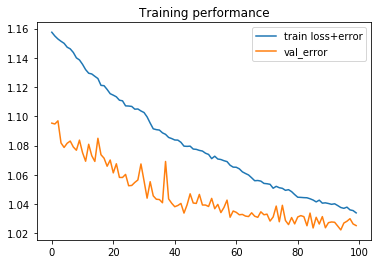

In [42]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [43]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

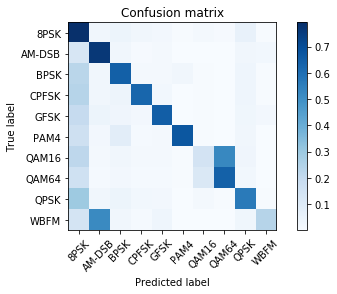

In [44]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



Overall Accuracy:  0.102765346336
Overall Accuracy:  0.105205131632
Overall Accuracy:  0.113006965041
Overall Accuracy:  0.122961524294
Overall Accuracy:  0.160436552967
Overall Accuracy:  0.267364002798
Overall Accuracy:  0.40012610759
Overall Accuracy:  0.518355212613
Overall Accuracy:  0.637136003199
Overall Accuracy:  0.742864799678
Overall Accuracy:  0.810219223151
Overall Accuracy:  0.828528628495
Overall Accuracy:  0.829303980579
Overall Accuracy:  0.832344656172
Overall Accuracy:  0.836724532811
Overall Accuracy:  0.835051546392
Overall Accuracy:  0.835929698422
Overall Accuracy:  0.833969149113
Overall Accuracy:  0.837075090903
Overall Accuracy:  0.832603243605


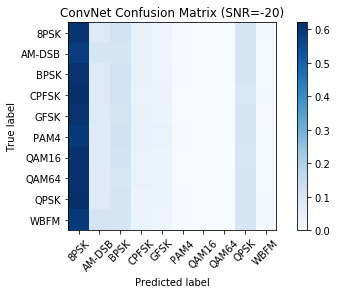

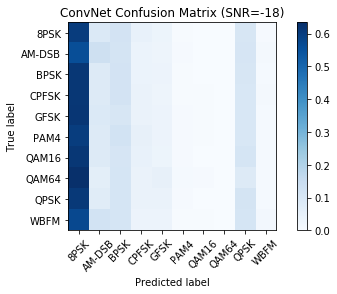

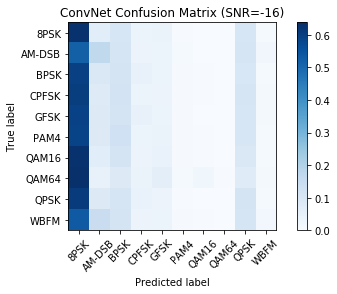

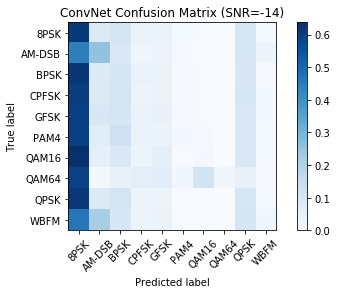

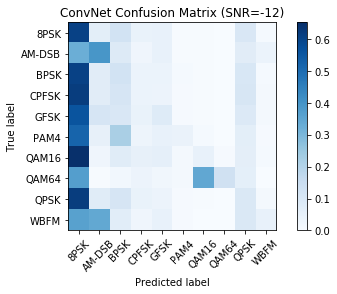

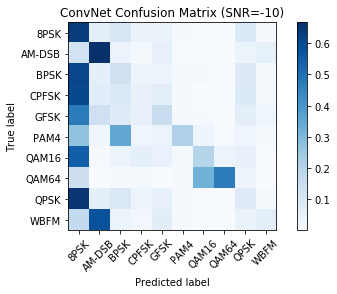

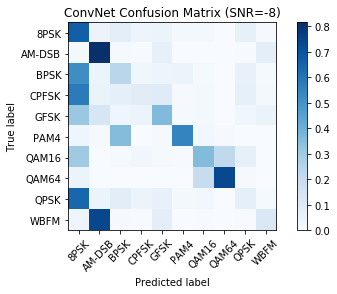

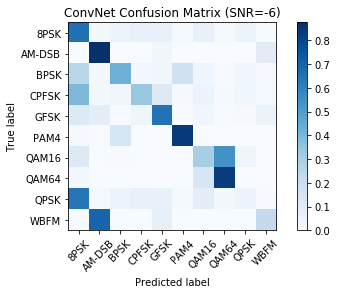

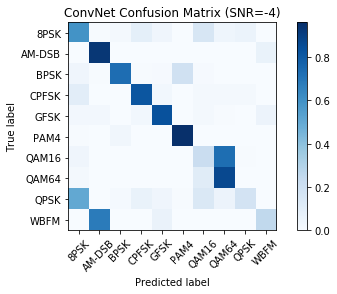

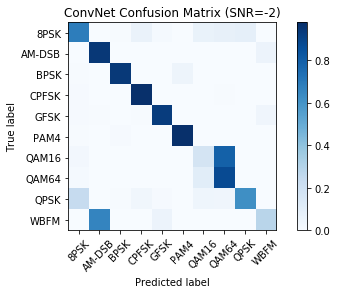

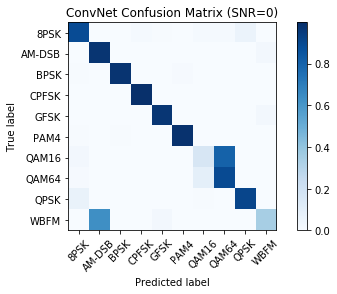

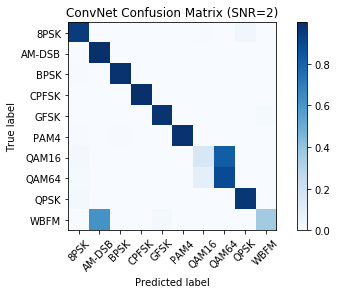

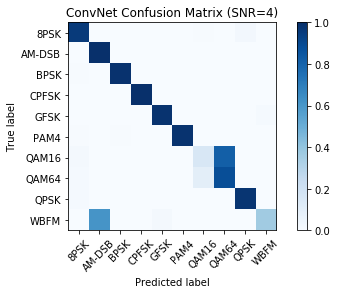

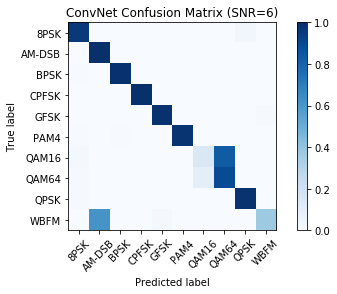

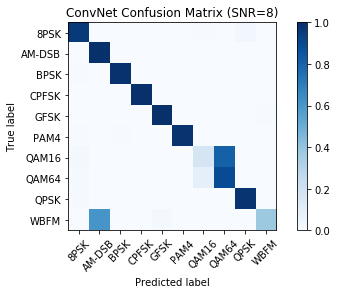

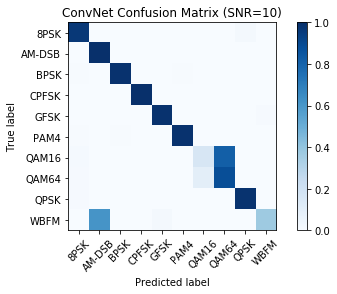

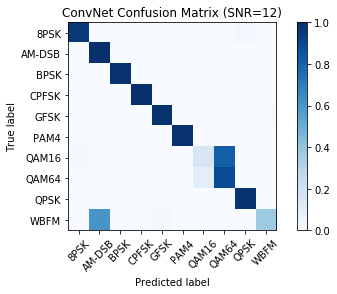

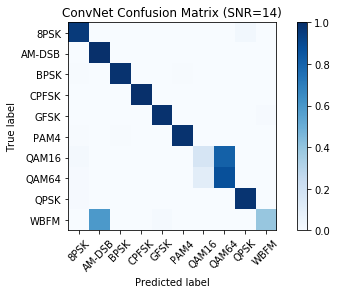

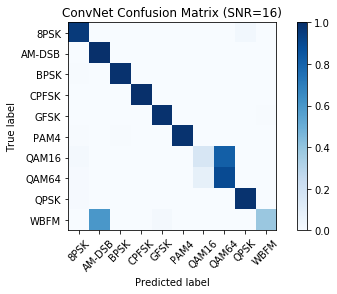

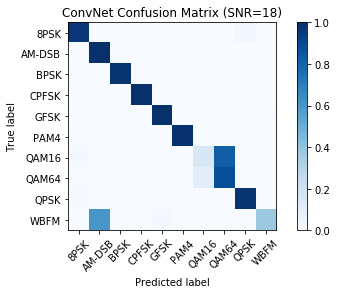

In [45]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print "Overall Accuracy: ", cor / (cor+ncor)
    acc[snr] = 1.0*cor/(cor+ncor)
    

In [46]:
# Save results to a pickle file for plotting later
print acc
fd = open('results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

{0: 0.810219223151039, 16: 0.83707509090302568, 2: 0.82852862849533959, 4: 0.82930398057929566, 6: 0.83234465617232811, 8: 0.83672453281109971, 12: 0.83592969842220888, 10: 0.83505154639175261, -20: 0.10276534633625008, 18: 0.83260324360474836, -18: 0.10520513163169852, -16: 0.11300696504149031, -14: 0.1229615242942772, -12: 0.16043655296709164, 14: 0.83396914911262232, -10: 0.26736400279822781, -8: 0.40012610758968575, -6: 0.51835521261315431, -4: 0.63713600319850738, -2: 0.74286479967841346}


Text(0.5,1,'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

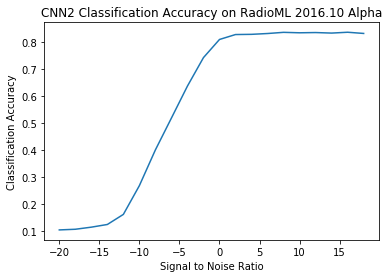

In [47]:
# Plot accuracy curve
plt.plot(snrs, map(lambda x: acc[x], snrs))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")